# Regression

## Objectives

*   Fit and evaluate a regression model to predict tenure levels for a prospect that will likely churn


## Inputs

* outputs/datasets/collection/TelcoCustomerChurn.csv
* instructions on which variables to use for data cleaning and feature engineering. They are found on its respectives notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict tenure
* labels map
* Feature Importance Plot



---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/churnometer/jupyter_notebooks'

We want to make the parent of the parent of current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/churnometer'

---

# Load Data for Modelling

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/TelcoCustomerChurn.csv")
      .query("Churn == 1")  # subset churned customer
      .drop(labels=['customerID','TotalCharges','Churn'],axis=1)  
                    # variables we will not need for this project
                    # we will not need Churn, since it is has only 1
  )

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1869 entries, 2 to 7041
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            1869 non-null   object 
 1   SeniorCitizen     1869 non-null   int64  
 2   Partner           1869 non-null   object 
 3   Dependents        1869 non-null   object 
 4   tenure            1869 non-null   int64  
 5   PhoneService      1869 non-null   object 
 6   MultipleLines     1869 non-null   object 
 7   InternetService   1869 non-null   object 
 8   OnlineSecurity    1869 non-null   object 
 9   OnlineBackup      1869 non-null   object 
 10  DeviceProtection  1869 non-null   object 
 11  TechSupport       1869 non-null   object 
 12  StreamingTV       1869 non-null   object 
 13  StreamingMovies   1869 non-null   object 
 14  Contract          1869 non-null   object 
 15  PaperlessBilling  1869 non-null   object 
 16  PaymentMethod     1869 non-null   object 


# Regressor: Sklearn

* In the ML Pipeline, we are using the raw data, therefore we need to create the pipeline with data cleaninig and feature engineering steps
  * This pipeline will be used in the Train Set, Test Set and Live Data

### ML pipeline for Data Cleaning and Feature Engineering

Load Estimators

In [5]:
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

 Pipeline for Data Cleaning and Feat Eng

In [6]:
def PipelineDataCleaningAndFeatureEngineering():
  pipeline_base = Pipeline(
      [

      ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = [ 'gender', 'Partner', 'Dependents', 'PhoneService',
                                                               'MultipleLines', 'InternetService', 'OnlineSecurity',
                                                               'OnlineBackup','DeviceProtection', 'TechSupport', 
                                                               'StreamingTV', 'StreamingMovies','Contract', 
                                                               'PaperlessBilling', 'PaymentMethod']
                                                  )
      ),      
       

      ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method="spearman",
                                                           threshold=0.6,selection_method="variance")
      ),
       
    ]
  )

  return pipeline_base

## ML Pipeline for Modelling and Hyperparameter Optimization

* Pipeline Optmization: Add Feature Scaling, Feature Selection and Model

In [7]:
def PipelineOptimization(model):
  pipe = PipelineDataCleaningAndFeatureEngineering()
  pipe.steps.append(["scaler", StandardScaler()])
  pipe.steps.append(["feat_selection", SelectFromModel(model)])
  pipe.steps.append(["model", model])
  
  return pipe

Custom Class for hyperparameter Optimization

In [8]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model=  PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Split Train Test Set

Quick recap in our raw dataset

In [9]:
print(df.shape)
df.head(3)

(1869, 18)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70
5,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65


Split Train and Test Set

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['tenure'],axis=1),
                                    df['tenure'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1495, 17) (1495,) 
* Test set: (374, 17) (374,)


## Target Distribution Analysis

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

def Target_DistributionAndStats(y_train,y_test):

  figure, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,3))
  sns.histplot(x=y_train, kde=True,ax=ax[0]).set(title='y train')
  sns.histplot(x=y_test, kde=True,ax=ax[1]).set(title='y test')
  plt.show()

  print("\n* Train set - target descriptive stats: \n", y_train.describe().to_frame().round(3))
  print(f"\n* Train set skewness: {y_train.skew().round(3)}, and kurtosis: {y_train.kurt().round(3)} \n\n")

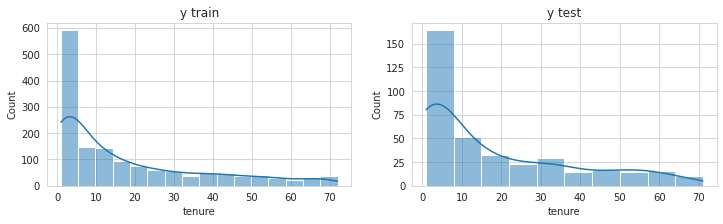


* Train set - target descriptive stats: 
          tenure
count  1495.000
mean     17.913
std      19.518
min       1.000
25%       2.000
50%      10.000
75%      28.000
max      72.000

* Train set skewness: 1.177, and kurtosis: 0.284 




In [12]:
Target_DistributionAndStats(y_train, y_test)

Target Transformation

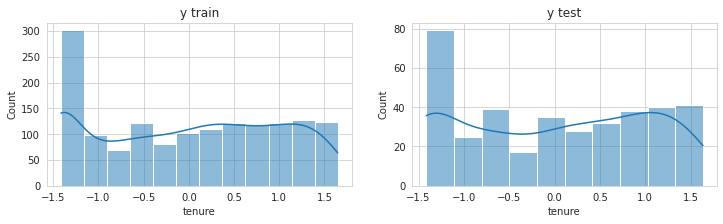


* Train set - target descriptive stats: 
          tenure
count  1495.000
mean      0.000
std       1.000
min      -1.414
25%      -0.994
50%       0.090
75%       0.868
max       1.648

* Train set skewness: -0.055, and kurtosis: -1.302 




In [13]:
import sklearn.preprocessing
target_transformer = sklearn.preprocessing.PowerTransformer(method='box-cox',standardize=True)

y_train = target_transformer.fit_transform(y_train.to_frame())
y_train = pd.Series(y_train.reshape(-1), name='tenure')

y_test = target_transformer.transform(y_test.to_frame())
y_test = pd.Series(y_test.reshape(-1), name='tenure')

Target_DistributionAndStats(y_train,y_test)

## Grid Search CV - Sklearn

### Use standard hyper parameters to find most suitable model

Define models for quick search

In [20]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    # "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}


Do a hyperparameter optmization search 

In [21]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [22]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.387012,0.461865,0.503968,0.0424318
0,LinearRegression,0.343394,0.420021,0.485439,0.0458841
4,AdaBoostRegressor,0.307589,0.378884,0.431785,0.0413897
2,RandomForestRegressor,0.183694,0.23775,0.29637,0.0391951
3,ExtraTreesRegressor,0.00121036,0.139266,0.21312,0.0767148
1,DecisionTreeRegressor,-0.202812,-0.0596575,0.0203846,0.0760251


Check best model

In [23]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

### Do extensive search on most suitable model to find best hyperparameter configuration

Define model and parameters, for Extensive Search

In [24]:
models_search = {
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may consider more hyperparameters and spend more time in this step

params_search = {
    "GradientBoostingRegressor":{
        'model__n_estimators': [100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10,None],
    }
}

Extensive GridSearch CV

In [25]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Check results

In [26]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
0,GradientBoostingRegressor,0.387012,0.461865,0.503968,0.0424318,0.1,3,100
7,GradientBoostingRegressor,0.377916,0.447425,0.496555,0.039552,0.01,3,300
1,GradientBoostingRegressor,0.346378,0.431174,0.47556,0.0470933,0.1,3,300
6,GradientBoostingRegressor,0.293759,0.338929,0.379381,0.028879,0.01,3,100
8,GradientBoostingRegressor,0.283865,0.338479,0.402475,0.0411954,0.01,10,100
9,GradientBoostingRegressor,0.268105,0.326855,0.410846,0.0483059,0.01,10,300
2,GradientBoostingRegressor,0.188722,0.249556,0.324808,0.0539987,0.1,10,100
10,GradientBoostingRegressor,0.161658,0.228122,0.308396,0.0472849,0.01,None,100
15,GradientBoostingRegressor,0.16612,0.197245,0.223178,0.0201625,0.001,10,300
17,GradientBoostingRegressor,0.151624,0.186236,0.22913,0.0248656,0.001,None,300


Check the best model

In [27]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

Parameters for best model

In [28]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 100}

Define the best regressor, based on search

In [29]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'Partner', 'Dependents',
                                           'PhoneService', 'MultipleLines',
                                           'InternetService', 'OnlineSecurity',
                                           'OnlineBackup', 'DeviceProtection',
                                           'TechSupport', 'StreamingTV',
                                           'StreamingMovies', 'Contract',
                                           'PaperlessBilling',
                                           'PaymentMethod'])),
                ('SmartCorrelatedSelecti...
                                                     'InternetService',
                                                     'OnlineSecurity',
                                                     'OnlineBackup',
                                                   

## Assess feature importance

* These are the 5 most important features in descending order. The model was trained on them: 
['MonthlyCharges', 'Contract', 'MultipleLines', 'PaymentMethod', 'Partner']


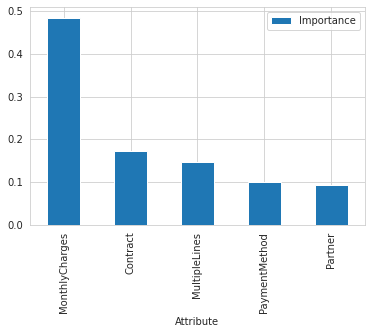

In [30]:
# after data cleaning and feat engine, the feature space changes
columns_after_data_cleaning_feat_eng = (PipelineDataCleaningAndFeatureEngineering()
                                        .fit_transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Attribute': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Attribute'].to_list()}")

df_feature_importance.plot(kind='bar',x='Attribute',y='Importance')
plt.show()

## Evaluate Regressor on Train and Test Sets

Custom Functions

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def model_score_train_test_set(X_train, y_train, X_test, y_test,pipeline):

	print("Model Evaluation \n")
	print("* Train Set")
	PredictionEvaluation(X_train,y_train,pipeline)

	print("* Test Set")
	PredictionEvaluation(X_test,y_test,pipeline)



def PredictionEvaluation(X,y,pipeline):
  prediction = pipeline.predict(X)

  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")

  


def PredictionVsActual_TrainTestSets(X_train, y_train, X_test, y_test,pipeline):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)
  Plot_Prediction_vs_Actual(y_train,pred_train,y_test, pred_test)



def Plot_Prediction_vs_Actual(TrainActual,TrainPred,TestActual,TestPred):

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

  sns.scatterplot(x=TrainActual , y=TrainPred, alpha=0.2, ax=axes[0])
  sns.lineplot(x=TrainActual , y=TrainActual, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=TestActual , y=TestPred, alpha=0.2, ax=axes[1])
  sns.lineplot(x=TestActual , y=TestActual, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

Evaluate Performance

In [ ]:
model_score_train_test_set(X_train, y_train, X_test, y_test,best_regressor_pipeline)
PredictionVsActual_TrainTestSets(X_train, y_train, X_test, y_test,best_regressor_pipeline)

# Regressor add PCA() in the pipeline: Sklearn

## Rewrite ML Pipeline for Modelling: add PCA step

* It will change only the PipelineOptimization() function

In [31]:
### PCA
from sklearn.decomposition import PCA

def PipelineOptimization(model):
  pipe = PipelineDataCleaningAndFeatureEngineering()
  pipe.steps.append(["PCA",PCA(n_components=3, random_state=0)])   #### PCA replace Feature Engineering
  pipe.steps.append(["scaler", StandardScaler()])
  pipe.steps.append(["model", model])
  
  return pipe

## Grid Search CV – Sklearn

### Use standard hyper parameters to find most suitable model

In [32]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    # "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}


Do a quick optmization search 

In [33]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [34]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.292139,0.380262,0.435378,0.0478961
2,RandomForestRegressor,0.259349,0.33728,0.400934,0.047094
4,AdaBoostRegressor,0.263693,0.333468,0.368808,0.0362284
0,LinearRegression,0.246823,0.308161,0.362973,0.0411205
3,ExtraTreesRegressor,0.209481,0.287381,0.356079,0.0511687
1,DecisionTreeRegressor,-0.211158,-0.12299,0.0592011,0.0945859


Check best model

In [35]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

### Do extensive search on most suitable model to find best hyperparameter configuration

Define model and parameters, for Extensive Search

In [36]:
models_search = {
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "GradientBoostingRegressor":{
        'model__n_estimators': [100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10, None],
    }
}

Extensive GridSearch CV

In [37]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 2 folds for each of 18 candidates, totalling 36 fits


Check results

In [38]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
0,GradientBoostingRegressor,0.339106,0.34793,0.356755,0.00882437,0.1,3,100
7,GradientBoostingRegressor,0.334237,0.344124,0.35401,0.00988622,0.01,3,300
1,GradientBoostingRegressor,0.289908,0.306167,0.322425,0.0162584,0.1,3,300
6,GradientBoostingRegressor,0.258206,0.271471,0.284736,0.013265,0.01,3,100
8,GradientBoostingRegressor,0.247784,0.25928,0.270776,0.0114963,0.01,10,100
9,GradientBoostingRegressor,0.196943,0.200796,0.204648,0.00385226,0.01,10,300
2,GradientBoostingRegressor,0.153219,0.164368,0.175517,0.0111486,0.1,10,100
15,GradientBoostingRegressor,0.158573,0.161558,0.164544,0.00298549,0.001,10,300
3,GradientBoostingRegressor,0.139146,0.15249,0.165834,0.013344,0.1,10,300
17,GradientBoostingRegressor,0.141225,0.144588,0.147951,0.00336278,0.001,None,300


Check the best model

In [39]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

Parameters for best model

In [40]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 100}

Define the best regressor, based on search

In [41]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'Partner', 'Dependents',
                                           'PhoneService', 'MultipleLines',
                                           'InternetService', 'OnlineSecurity',
                                           'OnlineBackup', 'DeviceProtection',
                                           'TechSupport', 'StreamingTV',
                                           'StreamingMovies', 'Contract',
                                           'PaperlessBilling',
                                           'PaymentMethod'])),
                ('SmartCorrelatedSelecti...
                                                     'Partner', 'Dependents',
                                                     'PhoneService',
                                                     'MultipleLines',
                                              

## Evaluate Regressor on Train and Tests Sets

In [ ]:
model_score_train_test_set(X_train, y_train, X_test, y_test,best_regressor_pipeline)
PredictionVsActual_TrainTestSets(X_train, y_train, X_test, y_test,best_regressor_pipeline)

# Convert Regression to Classification: Sklearn

### Convert target to bins and check if it is balanced

In [42]:
from feature_engine.discretisation import EqualFrequencyDiscretiser
disc = EqualFrequencyDiscretiser(q=3, variables=['tenure'])

df_clf = disc.fit_transform(df)
df_clf['tenure'].value_counts()

0    680
2    618
1    571
Name: tenure, dtype: int64

Visualize target distribution and range levels

* The classes represent the following ranges: 
{'tenure': [-inf, 4.0, 20.0, inf]} 



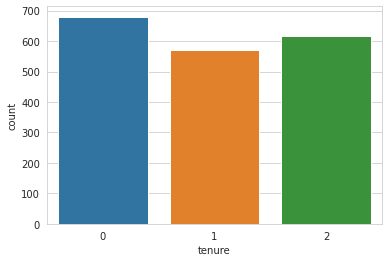

In [43]:
print(f"* The classes represent the following ranges: \n{disc.binner_dict_} \n")
sns.countplot(data=df_clf, x='tenure')
plt.show()

## Rewrite ML Pipeline for Modelling

In [44]:
def PipelineOptimization(model):
  pipe = PipelineDataCleaningAndFeatureEngineering()
  pipe.steps.append(["scaler", StandardScaler()])
  pipe.steps.append(["feat_selection", SelectFromModel(model)])
  pipe.steps.append(["model", model])
  return pipe

## Load estimators for classification

In [45]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

## Split Train Test Sets

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train, y_test = train_test_split(
                                    df_clf.drop(['tenure'],axis=1),
                                    df_clf['tenure'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1495, 17) (1495,) 
* Test set: (374, 17) (374,)


Check if target is balanced

In [47]:
y_train.value_counts(normalize=True).to_frame().round(2)

,tenure
0,0.36
2,0.33
1,0.31


## Grid Seach CV – Sklearn

### Use standard hyper parameters to find most suitable model

In [48]:
models_quick_search = {
    # "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

GridSearch CV

In [49]:
from sklearn.metrics import make_scorer, f1_score
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train,
                 scoring = make_scorer(f1_score, labels=[0], average=None),
                 n_jobs=-1,
                 cv=5)


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [50]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
4,AdaBoostClassifier,0.633333,0.65817,0.702929,0.0255069
2,GradientBoostingClassifier,0.630631,0.652244,0.691983,0.0223306
0,DecisionTreeClassifier,0.528634,0.570731,0.627615,0.0326084
3,ExtraTreesClassifier,0.511628,0.553961,0.589744,0.0267486
1,RandomForestClassifier,0.514286,0.551839,0.60262,0.0303015


Check best model

In [51]:
best_model = grid_search_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

### Do extensive search on most suitable model to find best hyperparameter configuration

Define models and parameters

In [52]:
models_search = {
    "AdaBoostClassifier":AdaBoostClassifier(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
params_search = {
    "AdaBoostClassifier":{
        'model__n_estimators': [50,100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
    }
}

Extensive GridSearch CV

In [53]:
from sklearn.metrics import make_scorer,  f1_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = make_scorer(f1_score, labels=[0], average=None),
           n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Check results

In [54]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__n_estimators
0,AdaBoostClassifier,0.645914,0.660355,0.685259,0.0141237,0.1,50
5,AdaBoostClassifier,0.648,0.65899,0.685259,0.0139766,0.01,300
1,AdaBoostClassifier,0.639344,0.65809,0.688,0.0170438,0.1,100
2,AdaBoostClassifier,0.639344,0.653516,0.688525,0.0182376,0.1,300
4,AdaBoostClassifier,0.637795,0.653186,0.685259,0.0167588,0.01,100
3,AdaBoostClassifier,0.625899,0.645665,0.685259,0.0205223,0.01,50
8,AdaBoostClassifier,0.59306,0.626239,0.695652,0.0369149,0.001,300
7,AdaBoostClassifier,0.583333,0.613487,0.645963,0.0227189,0.001,100
6,AdaBoostClassifier,0.583333,0.612383,0.645963,0.023794,0.001,50



Check the best model

In [55]:
best_model = grid_search_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

Parameters for best model
* We are saving this content for later

In [56]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.1, 'model__n_estimators': 50}

Define the best clf pipeline

In [57]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'Partner', 'Dependents',
                                           'PhoneService', 'MultipleLines',
                                           'InternetService', 'OnlineSecurity',
                                           'OnlineBackup', 'DeviceProtection',
                                           'TechSupport', 'StreamingTV',
                                           'StreamingMovies', 'Contract',
                                           'PaperlessBilling',
                                           'PaymentMethod'])),
                ('SmartCorrelatedSelecti...
                                                     'InternetService',
                                                     'OnlineSecurity',
                                                     'OnlineBackup',
                                                   

## Assess feature importance

We can assess feature importane for this model with `.feature_importances_`

* These are the 3 most important features in descending order. The model was trained on them: 
['MonthlyCharges', 'Contract', 'PaymentMethod']


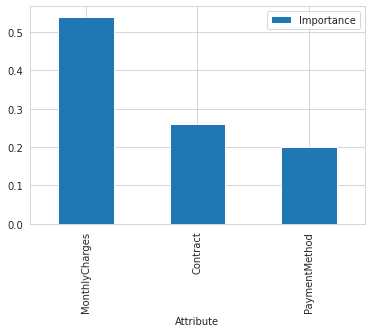

In [58]:
# after data cleaning and feat engine, the feature space changes
columns_after_data_cleaning_feat_eng = (PipelineDataCleaningAndFeatureEngineering()
                                        .fit_transform(X_train)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features = columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Attribute': columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()],
          'Importance': pipeline_clf['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

best_features = df_feature_importance['Attribute'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar',x='Attribute',y='Importance')
plt.show()

In [59]:
best_features_clf = best_features
best_features_clf

['MonthlyCharges', 'Contract', 'PaymentMethod']

## Evaluate Classifier on Train and Test Sets

Custom Function

In [60]:
from sklearn.metrics import classification_report, confusion_matrix

def ClfPredictionEvaluation(X,y,pipeline,LabelsMap):

  prediction = pipeline.predict(X)

  Map = list() 
  for key, value in LabelsMap.items():
    Map.append( str(key) + ": " + value)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(prediction,y),
        columns=[ ["Actual " + sub for sub in Map] ], 
        index = [ ["Prediction " + sub for sub in Map ]]
        # index=['Prediction 0', 'Prediction 1']
        ))
  print("\n")


  print('---  Classification Report  ---')
  print(classification_report(y, prediction),"\n")


def ClfPerformanceTrainTestSet(X_train,y_train,X_test,y_test,pipeline,LabelsMap):
  print("#### Train Set #### \n")
  ClfPredictionEvaluation(X_train,y_train,pipeline,LabelsMap)

  print("#### Test Set ####\n")
  ClfPredictionEvaluation(X_test,y_test,pipeline,LabelsMap)

Creates a dictionary that relates the class and numerical interval

In [61]:
n_classes = len(disc.binner_dict_['tenure']) - 1
classes_ranges = disc.binner_dict_['tenure'][1:-1]

labels_map = {}
for n in range(0,n_classes):
  if n == 0:
    labels_map[n] = f"<{classes_ranges[0]}"
  elif n == n_classes-1:
    labels_map[n] = f"+{classes_ranges[-1]}"
  else:
    labels_map[n] = f"{classes_ranges[n-1]} to {classes_ranges[n]}"

labels_map

{0: '<4.0', 1: '4.0 to 20.0', 2: '+20.0'}

In [62]:
ClfPerformanceTrainTestSet(X_train, y_train ,X_test, y_test,
                        pipeline_clf,
                        LabelsMap=labels_map )

#### Train Set #### 

---  Confusion Matrix  ---
                          Actual 0: <4.0 Actual 1: 4.0 to 20.0 Actual 2: +20.0
Prediction 0: <4.0                   418                   207              89
Prediction 1: 4.0 to 20.0             91                   151             103
Prediction 2: +20.0                   28                   109             299


---  Classification Report  ---
              precision    recall  f1-score   support

           0       0.59      0.78      0.67       537
           1       0.44      0.32      0.37       467
           2       0.69      0.61      0.65       491

    accuracy                           0.58      1495
   macro avg       0.57      0.57      0.56      1495
weighted avg       0.57      0.58      0.57      1495
 

#### Test Set ####

---  Confusion Matrix  ---
                          Actual 0: <4.0 Actual 1: 4.0 to 20.0 Actual 2: +20.0
Prediction 0: <4.0                   113                    40              22
Prediction 1:

# Which pipeline to choose?

We fitted multiple pipelines:
* Regression
* Regression with PCA
* Classifier

The regressor pipelines didn't reach the expected performance threshold of 0.7 for R2 score, for train and test set.

The classifier was tuned on recall for class 0, since we are interested to detect prospects that may churn soon. 
* It has reasonable performance for class 0 (<4 months) and can separate the opposite classes: class 0 (<4 months) and class 2 (+20 months).
* Class 1 (4 to 20 months) has weak performance. We will accept this limitation and will handle a prediction of class 1 as if it was a prediction of class 0.

# Refit pipeline with best features

## Split Train Test Set, only with best features

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train, y_test = train_test_split(
                                    df_clf.drop(['tenure'],axis=1),
                                    df_clf['tenure'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1495, 17) (1495,) 
* Test set: (374, 17) (374,)


Subset Best Features

In [64]:
X_train = X_train.filter(best_features_clf)

X_test = X_test.filter(best_features_clf)
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1495, 3) (1495,) 
* Test set: (374, 3) (374,)


Check how training data looks like now

In [65]:
X_train.head(3)

,MonthlyCharges,Contract,PaymentMethod
5779,95.55,One year,Electronic check
2608,34.50,Month-to-month,Electronic check
2464,77.15,Month-to-month,Electronic check


## Rewrite Data Cleaning and Feature Engineering Pipeline

In [66]:
def PipelineDataCleaningAndFeatureEngineering():
  pipeline_base = Pipeline(
      [
      ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary', 
                                                  # variables = ['MultipleLines', 'Contract', 
                                                  #              'PaymentMethod','Partner']
                                                  variables = ['Contract', 'PaymentMethod']
                                                  )
      ),
       
    ]
  )

  return pipeline_base

## Rewrite Modelling Pipeline (removes feat_selection)

In [67]:
def PipelineOptimization(model):
  pipe = PipelineDataCleaningAndFeatureEngineering()
  pipe.steps.append(["scaler", StandardScaler()])
  pipe.steps.append(["model", model])
  return pipe


## Grid Search CV – Sklearn

* using most suitable model from last section and it best hyperparameter configuration

We are using the same model from the last GridCV search

In [68]:
models_search

{'AdaBoostClassifier': AdaBoostClassifier(random_state=0)}

And the best parameters from the last GridCV search

In [69]:
best_parameters

{'model__learning_rate': 0.1, 'model__n_estimators': 50}

You will need to type in manually, since the hyperparameter values has to be a list. The previous dictonary is not in this format

In [70]:
params_search = {'AdaBoostClassifier':  {
    'model__learning_rate': [0.1],   # the value should be in []
    'model__n_estimators': [50]       # the value should be in []
}
}
params_search

{'AdaBoostClassifier': {'model__learning_rate': [0.1],
  'model__n_estimators': [50]}}

GridSearch CV

In [71]:
from sklearn.metrics import make_scorer, f1_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = make_scorer(f1_score, labels=[0], average=None),
           n_jobs=-1,cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/workspace/.pip-modules/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res =

NotFittedError: All estimators failed to fit


Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

Check the best model

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

Parameters for best model

In [ ]:
grid_search_pipelines[best_model].best_params_

Define the best clf pipeline

In [ ]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

## Assess feature importance

In [ ]:
# after data cleaning and feat engine, the feature space changes
columns_after_data_cleaning_feat_eng = (PipelineDataCleaningAndFeatureEngineering()
                                        .fit_transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Attribute': columns_after_data_cleaning_feat_eng,
          'Importance': pipeline_clf['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Attribute'].to_list()}")

df_feature_importance.plot(kind='bar',x='Attribute',y='Importance')
plt.show()

## Evaluate Classifier on Train and Test Sets

In [ ]:
ClfPerformanceTrainTestSet(X_train, y_train ,X_test, y_test,
                        pipeline_clf,
                        LabelsMap=labels_map )

# Push files to the repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* label map
* features importance plot

In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_tenure/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set : features and target

In [ ]:
X_train.head()

In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [ ]:
X_test.head()

In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline (that includes Data Cleaning and Feat Eng pipeline)

ML pipeline for predicting tenure

In [ ]:
pipeline_clf

In [ ]:
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline.pkl")

## Dictionary mapping target levels to bins

Map for converting numerical variable to categorical variable

In [ ]:
labels_map

In [ ]:
joblib.dump(value=labels_map ,
            filename=f"{file_path}/labels_map.pkl")

## Feature importance plot

In [ ]:
df_feature_importance.plot(kind='bar', x='Attribute', y='Importance')
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar',x='Attribute',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

## **Push** generated/new files from this Session to GitHub repo

Now you can push the files to the GitHub repo!!!

* Git status

In [ ]:
! git status

* Git commit

In [ ]:
CommitMsg = "added-files-predict-tenure"
! git add .
! git commit -m {CommitMsg}

* Git Push

In [ ]:
! git push origin main

Good job! Save the notebook in your repo.

Then, terminate the session (Runtime - Manage Sessions - Terminate)